# Emergency Vehicle Sound Identification Using CNNs and Spectrogram Analysis

This notebook implements a Convolutional Neural Network (CNN) for identifying emergency vehicle sirens using spectrogram analysis. The project addresses challenges like noisy environments to aid in intelligent traffic management systems.

## Objectives

* Preprocess audio aata into Spectrograms

* Design and implement CNN model

* Enchance model robustness with noise addition to simulate real-world conditions

* Evaluate model performance


## The Problem: Emergency Sound Identification in Noisy Environments

Emergency vehicle sirens are vital for urban safety, yet urban noise pollution can obscure these sounds. This notebook explores how CNNs can classify emergency sirens using spectrogram preprocessing techniques.

## Importing Necessary Libraries

In [1]:
# Audio Processing Libraries
import librosa
import librosa.display
from scipy import signal

# For Playing Audios
import IPython.display as ipd

# Array Processing
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix
from sklearn.metrics import confusion_matrix

# Create a DataFrame
import pandas as pd

import pickle

# Encode Categorical Targets
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Split Dataset
from sklearn.model_selection import train_test_split

import os

## Exploring the dataset

## Setting directories for training and testing datasets

In [2]:
# Set Dataset Paths
dataset_path = './dataset/'
training_path = os.path.join(dataset_path, 'training/')
testing_path = os.path.join(dataset_path, 'testing/')

## Function to Plot and Play Audio

In [3]:
def display_audio_info(file_path):
    plt.figure(figsize=(14, 5))
    data, sample_rate = librosa.load(file_path)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.title(f"Waveform of {os.path.basename(file_path)}")
    plt.show()
    return ipd.Audio(file_path)

## Display Example from Ambulance Class

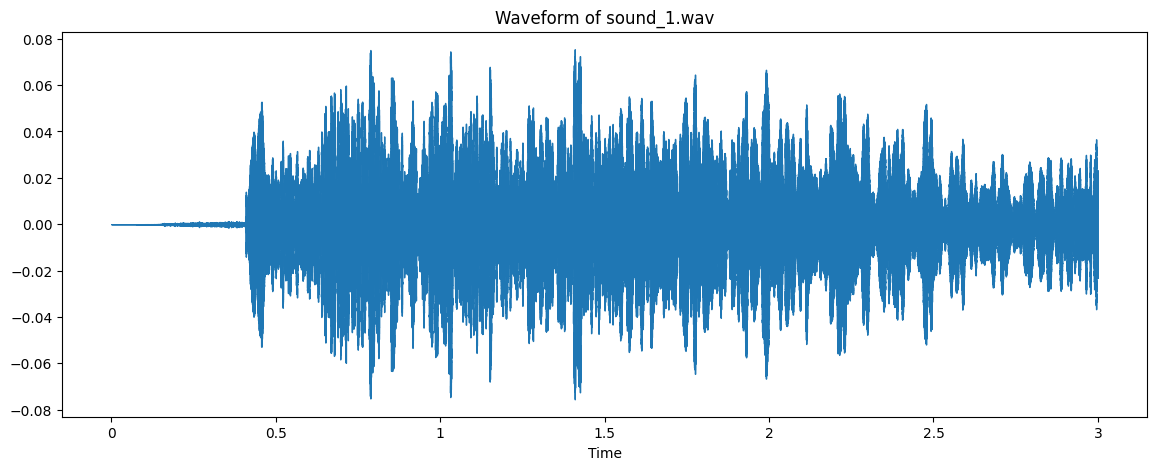

In [4]:
ambulance_example = os.path.join(training_path, 'ambulance', 'sound_1.wav')
display_audio_info(ambulance_example)

# Display Example from Firetruck Class

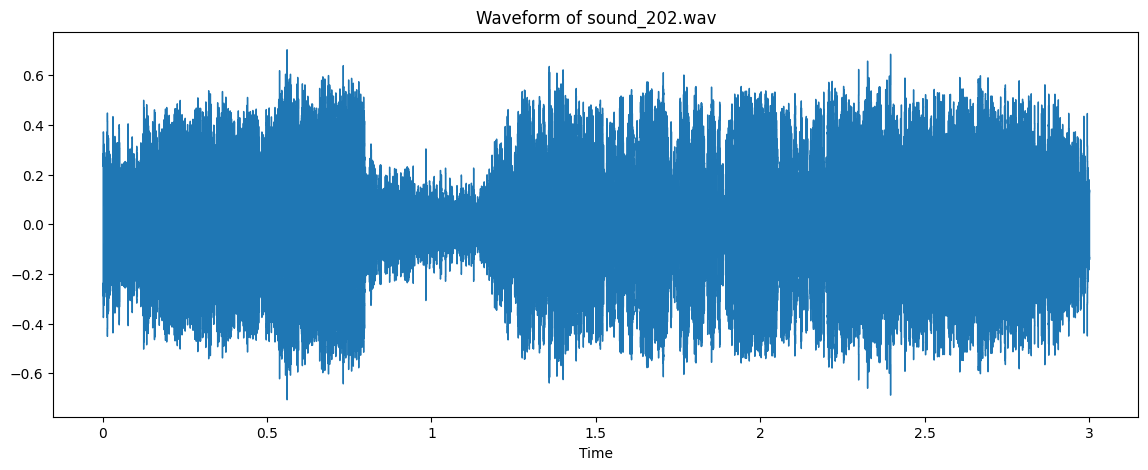

In [5]:
firetruck_example = os.path.join(training_path, 'firetruck', 'sound_202.wav')
display_audio_info(firetruck_example)

## Display Example from Traffic Class

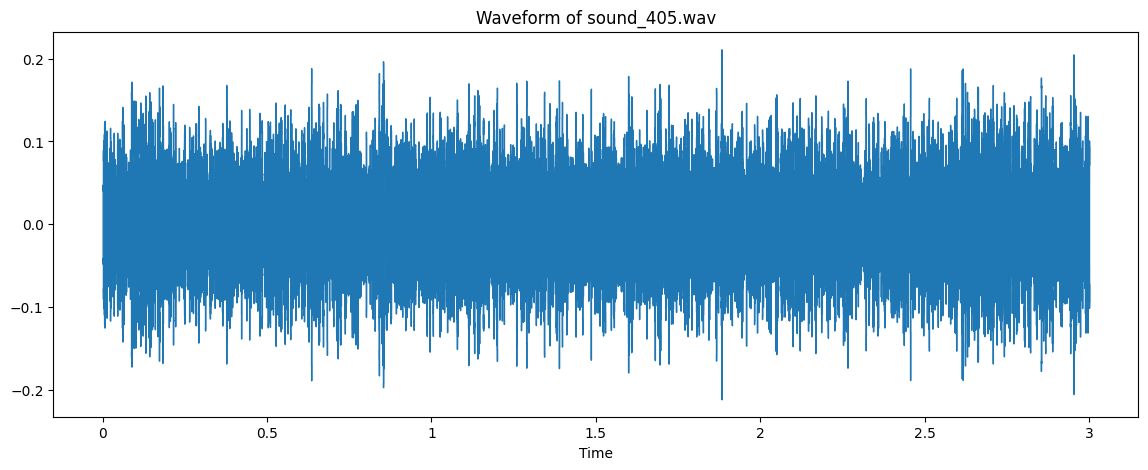

In [6]:
traffic_example = os.path.join(training_path, 'traffic', 'sound_405.wav')
display_audio_info(traffic_example)

## Feature extraction function

In [7]:
def add_noise(audio, noise_level=0.05):
    """Adds Gaussian noise to the audio signal."""
    noise = np.random.normal(0, noise_level, len(audio))
    return audio + noise

def features_extractor(file_name, apply_noise=False, noise_level=0.05):
    """Extracts MFCC features from an audio file, with optional noise augmentation."""
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    
    # Apply noise if enabled
    if apply_noise:
        audio = add_noise(audio, noise_level=noise_level)
    
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

Show extracted features

In [8]:
extracted_features = []
for split in ['training', 'testing']:
    for label in ['ambulance', 'firetruck', 'traffic']:
        folder_path = os.path.join(dataset_path, split, label)
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                # Extract original features
                data = features_extractor(file_path, apply_noise=False)
                extracted_features.append([data, label])
                
                # Extract features with noise augmentation
                noisy_data = features_extractor(file_path, apply_noise=True, noise_level=0.05)
                extracted_features.append([noisy_data, label])

Save the extrcted features

In [9]:
with open('./Extracted_Features.pkl', 'wb') as f:
    pickle.dump(extracted_features, f)

Loading extracted features

In [10]:
with open('./Extracted_Features.pkl', 'rb') as f:
    data = pickle.load(f)

Converting data frame

In [11]:
df = pd.DataFrame(data, columns=['feature', 'class'])
print(df.head())
print(df['class'].value_counts())

                                             feature      class
0  [-529.2778, 96.09123, -46.660313, -12.780942, ...  ambulance
1  [-87.35173740201176, -1.7675099918308679, -4.1...  ambulance
2  [-521.1548, 95.068886, -53.567135, -10.641551,...  ambulance
3  [-88.26924116312004, -2.1586639203172564, -2.9...  ambulance
4  [-38.777115, 104.3772, -40.953793, 1.848557, -...  ambulance
class
ambulance    480
firetruck    480
traffic      480
Name: count, dtype: int64


## Train-Test split

In [12]:
#Split Data into Train/Test Sets
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

#Label Encoding
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True
)

Display dataset shape

In [13]:
# Display Dataset Shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1152, 40), y_train shape: (1152, 3)
X_test shape: (288, 40), y_test shape: (288, 3)


## CNN Model

In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report

def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train.shape[1], 1))
    conv = Conv1D(64, kernel_size=3, padding='same', activation=activation)(inputs)
    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = GlobalMaxPooling1D()(conv)
    conv = Dense(32, activation=activation)(conv)
    outputs = Dense(y_train.shape[1], activation='softmax')(conv)
    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Prepare features

In [15]:
X_train_features = X_train.reshape(len(X_train), -1, 1)
X_test_features = X_test.reshape(len(X_test), -1, 1)

## Training

In [16]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate=0.3)
history = model_cnn.fit(
    X_train_features,
    y_train,
    validation_data=(X_test_features, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4226 - loss: 5.2107 - val_accuracy: 0.8264 - val_loss: 0.6023
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7001 - loss: 1.5911 - val_accuracy: 0.8229 - val_loss: 0.5090
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7434 - loss: 1.0267 - val_accuracy: 0.8264 - val_loss: 0.4492
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7621 - loss: 0.8332 - val_accuracy: 0.8368 - val_loss: 0.3838
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7355 - loss: 0.7955 - val_accuracy: 0.8403 - val_loss: 0.4017
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8044 - loss: 0.6325 - val_accuracy: 0.8438 - val_loss: 0.3664
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8211 - loss: 0.5713 - val_accuracy: 0.8507 - val_loss: 0.3491
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8241 - loss: 0.5071 - val_accuracy: 0.8403 - val_loss

## Emergency Vehicle Sound Identification Using CNNs and Spectrogram Analysis

## Training History

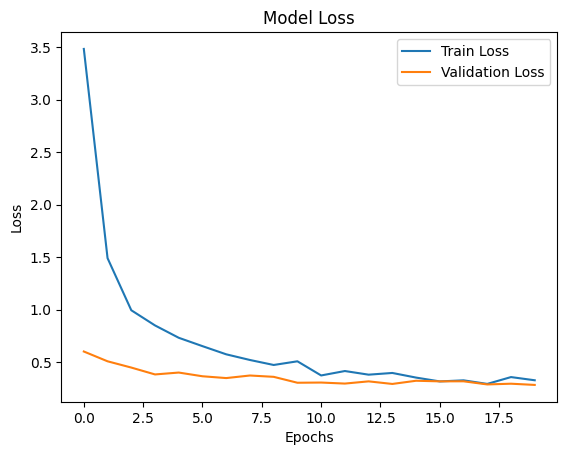

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Evaluation

In [18]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print(f"Test Accuracy: {acc}")

# Classification Report
y_pred = np.argmax(model_cnn.predict(X_test_features), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=labelencoder.classes_))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.3281 
Test Accuracy: 0.8506944179534912
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   ambulance       0.80      0.76      0.78        96
   firetruck       0.81      0.80      0.81        96
     traffic       0.93      0.99      0.96        96

    accuracy                           0.85       288
   macro avg       0.85      0.85      0.85       288
weighted avg       0.85      0.85      0.85       288



## Confusion matrix

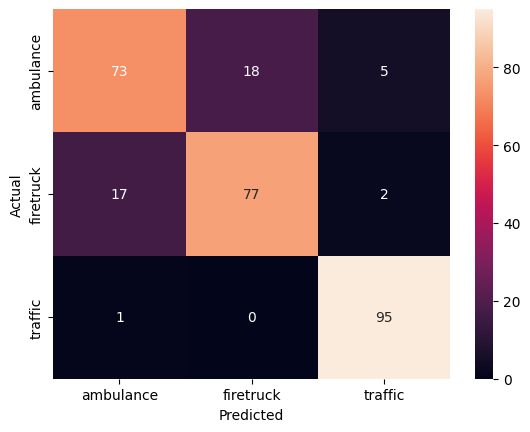

In [19]:
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
# Function to get sorted file names from a specific directory
def get_file_names(folder_path):
    file_names = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.wav'):
                file_names.append(file)
    return sorted(file_names)  # Ensure consistent order

# Get training file names
train_file_names = []
for label in ['ambulance', 'firetruck', 'traffic']:
    folder = os.path.join(training_path, label)
    train_file_names.extend(get_file_names(folder))

# Get testing file names
test_file_names = []
for label in ['ambulance', 'firetruck', 'traffic']:
    folder = os.path.join(testing_path, label)
    test_file_names.extend(get_file_names(folder))


Saving classification results to csv

In [21]:
def save_results_to_csv(folder_path, y_true, y_pred, file_names, labelencoder, output_file_name):
    # Convert one-hot encoded labels to categorical indices
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_pred_confidence = np.max(y_pred, axis=1)  # Confidence score

    # Decode labels to class names
    actual_labels = labelencoder.inverse_transform(y_true_labels)
    predicted_labels = labelencoder.inverse_transform(y_pred_labels)

    # Extract sound numbers from file names
    sound_numbers = [os.path.splitext(file)[0] for file in file_names]

    # Debug lengths
    print(f"Length of sound_numbers: {len(sound_numbers)}")
    print(f"Length of actual_labels: {len(actual_labels)}")
    print(f"Length of predicted_labels: {len(predicted_labels)}")
    print(f"Length of confidence_scores: {len(y_pred_confidence)}")

    if len(sound_numbers) == len(actual_labels) == len(predicted_labels) == len(y_pred_confidence):
        # Create DataFrame
        results_df = pd.DataFrame({
            "sound_number": sound_numbers,
            "actual": actual_labels,
            "predicted": predicted_labels,
            "confidence_score": y_pred_confidence
        })

        # Save CSV
        output_path = os.path.join(folder_path, output_file_name)
        print(f"Saving results to: {output_path}")
        results_df.to_csv(output_path, index=False, mode='w')
        print(f"Results saved to {output_path}")
    else:
        print("Error: Lists have different lengths.")

# Ensure the file names match the length of y_train and y_test
train_file_names = train_file_names[:len(y_train)]
test_file_names = test_file_names[:len(y_test)]

# Save Training Results
save_results_to_csv(
    folder_path="./dataset/training/",
    y_true=y_train,
    y_pred=model_cnn.predict(X_train_features),
    file_names=train_file_names,  # Use truncated list
    labelencoder=labelencoder,
    output_file_name="training.csv"
)

print(f"Test File Names: {test_file_names}")
print(f"Expected Testing Samples: {len(y_test)}")

# Truncate testing labels to match available file names (temporary solution)
y_test = y_test[:len(test_file_names)]
X_test_features = X_test_features[:len(test_file_names)]

# Save Testing Results
save_results_to_csv(
    folder_path="./dataset/testing/",
    y_true=y_test,
    y_pred=model_cnn.predict(X_test_features),
    file_names=test_file_names,
    labelencoder=labelencoder,
    output_file_name="testing.csv"
)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Length of sound_numbers: 600
Length of actual_labels: 1152
Length of predicted_labels: 1152
Length of confidence_scores: 1152
Error: Lists have different lengths.
Test File Names: ['sound_161.wav', 'sound_162.wav', 'sound_163.wav', 'sound_164.wav', 'sound_165.wav', 'sound_166.wav', 'sound_167.wav', 'sound_168.wav', 'sound_169.wav', 'sound_170.wav', 'sound_171.wav', 'sound_172.wav', 'sound_173.wav', 'sound_174.wav', 'sound_175.wav', 'sound_176.wav', 'sound_177.wav', 'sound_178.wav', 'sound_179.wav', 'sound_180.wav', 'sound_181.wav', 'sound_182.wav', 'sound_183.wav', 'sound_184.wav', 'sound_185.wav', 'sound_186.wav', 'sound_187.wav', 'sound_188.wav', 'sound_189.wav', 'sound_190.wav', 'sound_191.wav', 'sound_192.wav', 'sound_193.wav', 'sound_194.wav', 'sound_195.wav', 'sound_196.wav', 'sound_197.wav', 'sound_198.wav', 'sound_199.wav', 'sound_200.wav', 'sound_361.wav', 'sound_362.wav', 'sound_363.wav', 'sound_364.wav', 'sound_365.wav', 'sound_366.wav